# Libraries

In [2]:
import pandas as pd

# Loading the dataset

In [3]:
# 1. Load the raw tables, forcing REPORT_ID to stay as strings
crash = pd.read_csv(
    r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Dataset\2019-2023_DATA_SA_Crash.csv",
    dtype={"REPORT_ID": str},
    parse_dates=[["Year", "Month", "Day", "Time"]],
    dayfirst=True
)
units = pd.read_csv(
    r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Dataset\2019-2023_DATA_SA_Units.csv",
    dtype={"REPORT_ID": str}
)
casualty = pd.read_csv(
    r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Dataset\2019-2023_DATA_SA_Casualty.csv",
    dtype={"REPORT_ID": str}
)


# Making NEW_ID to help merge the dataset

In [4]:
# 2. In Crash: recover the original crash‐sequence prefix, then build a new consistent key
crash["SEQ"] = crash["REPORT_ID"].str.split("/").str[0]
crash["NEW_ID"] = (
    crash["Year_Month_Day_Time"].dt.strftime("%Y-%m-%d_%H%M")
    + "_"
    + crash["SEQ"]
)


# Propagating the New Key into Units & Casualty

In [5]:
# 3. Propagate NEW_ID into Units and Casualty by merging on the old key
units = units.merge(crash[["REPORT_ID", "NEW_ID"]], on="REPORT_ID", how="left")
casualty = casualty.merge(crash[["REPORT_ID", "NEW_ID"]], on="REPORT_ID", how="left")


# Replacing the Old REPORT_ID Everywhere

In [6]:
# 4. Drop the corrupted REPORT_ID and rename NEW_ID → REPORT_ID
for df in (crash, units, casualty):
    df.drop(columns="REPORT_ID", inplace=True)
    df.rename(columns={"NEW_ID": "REPORT_ID"}, inplace=True)


# Saving the Cleaned Tables

In [7]:
import os

# Directory where you want to save the cleaned files
output_dir = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned DataFrames
crash.to_csv(os.path.join(output_dir, "Crash_cleaned.csv"), index=False)
units.to_csv(os.path.join(output_dir, "Units_cleaned.csv"), index=False)
casualty.to_csv(os.path.join(output_dir, "Casualty_cleaned.csv"), index=False)


# Merging the dataset

In [8]:
import pandas as pd
import os

# 1. Load cleaned tables
crash    = pd.read_csv(r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Crash_cleaned.csv",    dtype=str)
units    = pd.read_csv(r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Units_cleaned.csv",    dtype=str)
casualty = pd.read_csv(r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Casualty_cleaned.csv", dtype=str)

# 2. Merge Crash + Units (inner is fine since every crash has ≥1 unit)
crash_units = pd.merge(units, crash, on="REPORT_ID", how="inner")

# 3. Left-join Casualty onto crash_units so you retain every unit (and crash) even if no casualty
full_crash = pd.merge(
    crash_units,
    casualty,
    left_on=["REPORT_ID", "Unit No"],
    right_on=["REPORT_ID", "UND_UNIT_NUMBER"],
    how="left"   # ← key change here
)

# 4. Export the merged dataset
output_dir = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset"
os.makedirs(output_dir, exist_ok=True)
full_crash.to_csv(os.path.join(output_dir, "Full_Crash_Merged_All.csv"), index=False)

print("Merged dataset with all units saved to Full_Crash_Merged_All.csv")


Merged dataset with all units saved to Full_Crash_Merged_All.csv


# Backup weather data

In [9]:
import requests
import pandas as pd
import os

# ─── 1. Define Archive API request ───────────────────────────────────────────
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": -34.9285,
    "longitude": 138.6007,
    "start_date": "2019-01-01",
    "end_date": "2023-09-13",
    "hourly": "temperature_2m,precipitation,windspeed_10m,relativehumidity_2m",
    "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum",
    "timezone": "UTC",            # fetch in UTC
    "cell_selection": "land"
}

# ─── 2. Fetch the JSON payload ────────────────────────────────────────────────
resp = requests.get(url, params=params)
resp.raise_for_status()
data = resp.json()

# ─── 3. Build & clean the hourly DataFrame ───────────────────────────────────
hourly = pd.DataFrame(data["hourly"])

# Parse ISO strings as UTC, convert to Adelaide time, then remove tz info
hourly["time"] = (
    pd.to_datetime(hourly["time"], utc=True)
      .dt.tz_convert("Australia/Adelaide")
      .dt.tz_localize(None)   # drop the timezone, leaving naive local time
)

# Split out date/hour if desired
hourly["date"] = hourly["time"].dt.date
hourly["hour"] = hourly["time"].dt.hour

# ─── 4. Build & clean the daily DataFrame ────────────────────────────────────
daily = pd.DataFrame(data["daily"])

daily["time"] = (
    pd.to_datetime(daily["time"], utc=True)
      .dt.tz_convert("Australia/Adelaide")
      .dt.tz_localize(None)
)
daily["date"] = daily["time"].dt.date

# ─── 5. Save to your Backup Dataset folder ───────────────────────────────────
backup_dir = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Backup Dataset"
os.makedirs(backup_dir, exist_ok=True)

hourly.to_csv(
    os.path.join(backup_dir, "adelaide_weather_hourly_2019_2023_fixed.csv"),
    index=False
)
daily.to_csv(
    os.path.join(backup_dir, "adelaide_weather_daily_2019_2023.csv"),
    index=False
)

print("✅ Saved corrected hourly and daily weather CSVs to:", backup_dir)


✅ Saved corrected hourly and daily weather CSVs to: C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Backup Dataset


# Creating daily_seq for simplicity and fixing coloumn sequences

In [10]:
import pandas as pd
import os

# ─── 1. Load the merged dataset ───────────────────────────────────────────────
merged_path = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All.csv"
df = pd.read_csv(merged_path, dtype=str)

# ─── 2. Parse crash datetime and date ────────────────────────────────────────
parts = df['REPORT_ID'].str.rsplit('_', n=1, expand=True)
df['CRASH_DATETIME'] = pd.to_datetime(parts[0], format='%Y-%m-%d_%H%M')
df['CRASH_DATE'] = df['CRASH_DATETIME'].dt.date

# ─── 3. Assign daily_seq per unique crash ────────────────────────────────────
# Create a DataFrame of unique crashes
unique_crashes = (
    df[['REPORT_ID', 'CRASH_DATE', 'CRASH_DATETIME']]
    .drop_duplicates(subset=['REPORT_ID'])
    .sort_values(['CRASH_DATE', 'CRASH_DATETIME'])
)
# Assign 1,2,3... per day
unique_crashes['daily_seq'] = unique_crashes.groupby('CRASH_DATE').cumcount() + 1

# Merge the proper daily_seq back into the full dataset
df = df.merge(
    unique_crashes[['REPORT_ID', 'daily_seq']], 
    on='REPORT_ID', 
    how='left'
)

# ─── 4. (Optional) Reorder columns ────────────────────────────────────────────
# For illustration, bring REPORT_ID, CRASH_DATETIME, CRASH_DATE, daily_seq to front
front_cols = ['REPORT_ID', 'CRASH_DATETIME', 'CRASH_DATE', 'daily_seq']
rest = [c for c in df.columns if c not in front_cols]
df = df[front_cols + rest]

# ─── 5. Save updated file ───────────────────────────────────────────────────
output_path = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_with_seq.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)

print("✅ Updated dataset saved with unique daily_seq per crash:", output_path)


✅ Updated dataset saved with unique daily_seq per crash: C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_with_seq.csv


# Setting everything chronologically

In [11]:
import pandas as pd
import os

# ─── 1. Load the merged dataset with crash datetime parsed ────────────────────
merged_path = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_with_seq.csv"
df = pd.read_csv(merged_path, dtype=str)
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'])

# ─── 2. Sort rows chronologically by crash datetime ──────────────────────────
df = df.sort_values('CRASH_DATETIME').reset_index(drop=True)

# ─── 3. Save the chronologically ordered dataset ─────────────────────────────
output_path = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_chronological.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)

print("✅ Saved chronologically ordered dataset to:", output_path)


✅ Saved chronologically ordered dataset to: C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_chronological.csv


# Initial Analysis of the dataset

In [12]:
import pandas as pd

# ─── 1. Load the chronologically ordered merged dataset ───────────────────────
file_path = r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_chronological.csv"
df = pd.read_csv(file_path, dtype=str, parse_dates=['CRASH_DATETIME'])

# ─── 2. Basic metrics ─────────────────────────────────────────────────────────
metrics = {
    'Total Rows': len(df),
    'Unique REPORT_IDs': df['REPORT_ID'].nunique(),
    'Unique (REPORT_ID, Unit No) pairs': df[['REPORT_ID', 'Unit No']].drop_duplicates().shape[0],
    'Columns Count': df.shape[1],
    'Date Range (first)': df['CRASH_DATETIME'].min(),
    'Date Range (last)': df['CRASH_DATETIME'].max()
}
print("=== Dataset Metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v}")

# ─── 3. Missingness overview ──────────────────────────────────────────────────
total = len(df)
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing %': (df.isnull().sum().values / total * 100).round(2)
})
print("\n=== Missingness Overview ===")
print(missing_info)

# ─── 4. Sample head and tail ─────────────────────────────────────────────────
print("\n=== First 5 Rows (Chronological Start) ===")
print(df.head(5))
print("\n=== Last 5 Rows (Chronological End) ===")
print(df.tail(5))


=== Dataset Metrics ===
Total Rows: 137618
Unique REPORT_IDs: 63069
Unique (REPORT_ID, Unit No) pairs: 134724
Columns Count: 63
Date Range (first): 2019-01-01 00:00:00
Date Range (last): 2023-12-07 23:03:00

=== Missingness Overview ===
            Column  Missing Count  Missing %
0        REPORT_ID              0       0.00
1   CRASH_DATETIME              0       0.00
2       CRASH_DATE              0       0.00
3        daily_seq              0       0.00
4          Unit No              0       0.00
..             ...            ...        ...
58      Thrown Out         113764      82.67
59   Injury Extent         112433      81.70
60       Seat Belt         118248      85.92
61          Helmet         133074      96.70
62        Hospital         118047      85.78

[63 rows x 3 columns]

=== First 5 Rows (Chronological Start) ===
                     REPORT_ID      CRASH_DATETIME  CRASH_DATE daily_seq  \
0  2019-01-01_0000_2019-606-13 2019-01-01 00:00:00  2019-01-01         2   
1  2

# Truncating the weather data match with the crash data set because of data mismatch

In [13]:
import pandas as pd

# 1. Load your chronological crash file
crash = pd.read_csv(
    r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_chronological.csv",
    parse_dates=["CRASH_DATETIME"],
    dtype={"REPORT_ID": str}
)

# 2. Truncate to match weather coverage (through 2023-09-13)
last_weather_date = pd.to_datetime("2023-09-13 23:59:59")
crash = crash[ crash["CRASH_DATETIME"] <= last_weather_date ].reset_index(drop=True)

# 3. (Optional) Drop rows before 2019-01-01 if any stray earlier data
first_weather_date = pd.to_datetime("2019-01-01 00:00:00")
crash = crash[ crash["CRASH_DATETIME"] >= first_weather_date ].reset_index(drop=True)

print(f"Crash records for analysis: {len(crash)} rows from {crash['CRASH_DATETIME'].min()} to {crash['CRASH_DATETIME'].max()}")


Crash records for analysis: 130573 rows from 2019-01-01 00:00:00 to 2023-09-07 23:55:00


# Aggregating weather and crash data

Crash records for analysis: 130573 rows from 2019-01-01 00:00:00 to 2023-09-07 23:55:00

=== Weather Columns After Cleaning ===
date                   object
precipitation_sum     float64
temperature_2m_max    float64
dtype: object 

=== Daily Merged Sample ===
         date  crash_count  total_casualties  fatalities  precipitation_sum  \
0  2019-01-01          159                73           0                0.0   
1  2019-01-02          157                83           0                0.0   
2  2019-01-03          183               101           0                0.0   
3  2019-01-04          134                59           0                0.0   
4  2019-01-05          114                54           0                0.0   

   temperature_2m_max  
0                29.2  
1                32.1  
2                39.1  
3                24.1  
4                21.8   

=== Summary Statistics ===
       crash_count  total_casualties  fatalities  precipitation_sum  \
count   399.000000 

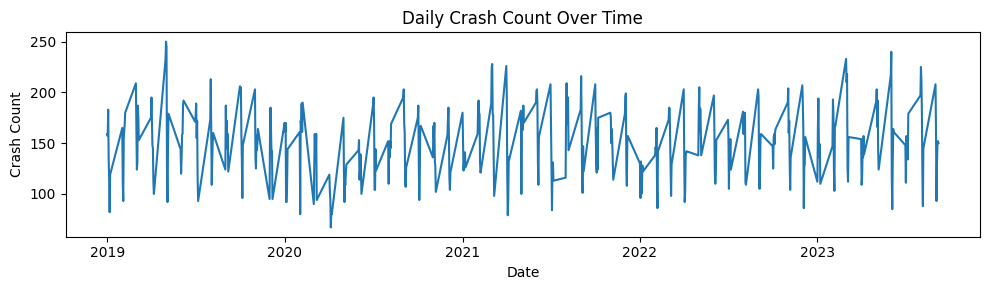

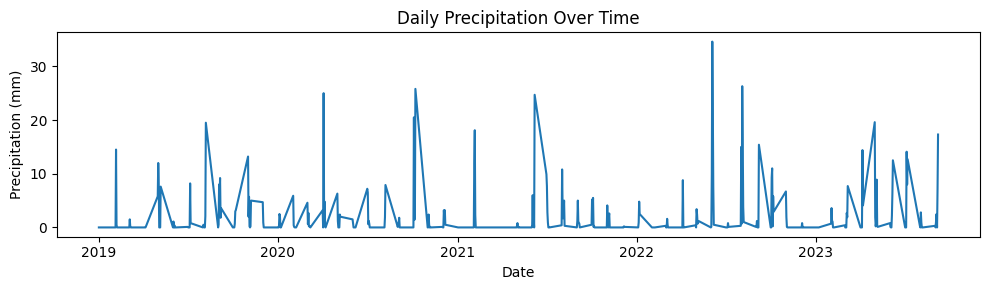

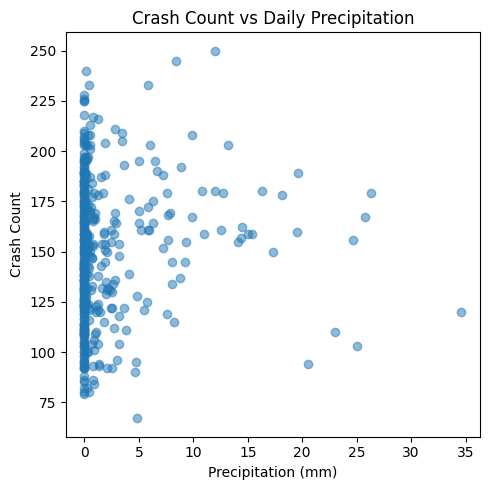

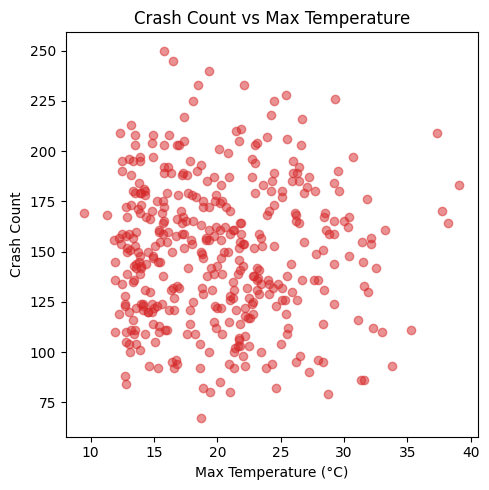

=== Correlation Matrix ===
                    crash_count  precipitation_sum  temperature_2m_max
crash_count            1.000000           0.079824           -0.004931
precipitation_sum      0.079824           1.000000           -0.199901
temperature_2m_max    -0.004931          -0.199901            1.000000 



C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


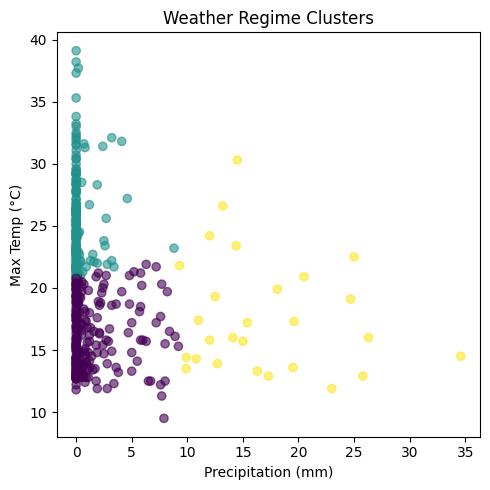

=== Mean Crash Count by Weather Cluster ===
weather_cluster
0    150.115741
1    147.320513
2    163.703704
Name: crash_count, dtype: float64


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ─── 1. Load and truncate crash data ─────────────────────────────────────────
crash = pd.read_csv(
    r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Cleaned Dataset\Full_Crash_Merged_All_chronological.csv",
    parse_dates=["CRASH_DATETIME"], dtype={"REPORT_ID": str}
)
last_weather_date = pd.to_datetime("2023-09-13 23:59:59")
first_weather_date = pd.to_datetime("2019-01-01 00:00:00")
crash = crash[(crash["CRASH_DATETIME"] >= first_weather_date) & 
              (crash["CRASH_DATETIME"] <= last_weather_date)].reset_index(drop=True)
crash['date'] = crash['CRASH_DATETIME'].dt.date
print(f"Crash records for analysis: {len(crash)} rows from {crash['CRASH_DATETIME'].min()} to {crash['CRASH_DATETIME'].max()}\n")

# ─── 2. Load and clean daily weather data ────────────────────────────────────
weather = pd.read_csv(
    r"C:\Users\Aniket Shetty\OneDrive\Documents\Trimester 6\Big Data Analysis and Project\Backup Dataset\adelaide_weather_daily_2019_2023.csv"
)
# Drop old 'date' column if both exist
if 'date' in weather.columns and 'time' in weather.columns:
    weather.drop(columns=['date'], inplace=True)
# Rename 'time' to 'timestamp' and parse
weather.rename(columns={'time': 'timestamp'}, inplace=True)
weather['date'] = pd.to_datetime(weather['timestamp'], errors='coerce').dt.date
# Keep only required columns
weather = weather[['date', 'precipitation_sum', 'temperature_2m_max']]
print("=== Weather Columns After Cleaning ===")
print(weather.dtypes, "\n")

# ─── 3. Aggregate crash to daily counts ──────────────────────────────────────
daily = crash.groupby('date').agg(
    crash_count=('REPORT_ID', 'nunique'),
    total_casualties=('Casualty Type', 'count'),
    fatalities=('Injury Extent', lambda x: (x == 'Killed').sum())
).reset_index()

# Merge with weather
daily = daily.merge(weather, on='date', how='left')

# ─── 4. Display initial findings ────────────────────────────────────────────
print("=== Daily Merged Sample ===")
print(daily.head(), "\n")

print("=== Summary Statistics ===")
print(daily[['crash_count', 'total_casualties', 'fatalities',
            'precipitation_sum', 'temperature_2m_max']].describe(), "\n")

# ─── 5. Time-series plots ──────────────────────────────────────────────────
plt.figure(figsize=(10, 3))
plt.plot(daily['date'], daily['crash_count'], label='Crash Count')
plt.title('Daily Crash Count Over Time'); plt.xlabel('Date'); plt.ylabel('Crash Count')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 3))
plt.plot(daily['date'], daily['precipitation_sum'], label='Precipitation (mm)', color='tab:blue')
plt.title('Daily Precipitation Over Time'); plt.xlabel('Date'); plt.ylabel('Precipitation (mm)')
plt.tight_layout(); plt.show()

# ─── 6. Scatter plots ───────────────────────────────────────────────────────
plt.figure(figsize=(5, 5))
plt.scatter(daily['precipitation_sum'], daily['crash_count'], alpha=0.5)
plt.title('Crash Count vs Daily Precipitation'); plt.xlabel('Precipitation (mm)'); plt.ylabel('Crash Count')
plt.tight_layout(); plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(daily['temperature_2m_max'], daily['crash_count'], alpha=0.5, color='tab:red')
plt.title('Crash Count vs Max Temperature'); plt.xlabel('Max Temperature (°C)'); plt.ylabel('Crash Count')
plt.tight_layout(); plt.show()

# ─── 7. Correlation matrix ──────────────────────────────────────────────────
corr = daily[['crash_count', 'precipitation_sum', 'temperature_2m_max']].corr()
print("=== Correlation Matrix ===")
print(corr, "\n")

# ─── 8. Cluster weather regimes ─────────────────────────────────────────────
features = daily[['precipitation_sum', 'temperature_2m_max']].fillna(0)
X = StandardScaler().fit_transform(features)
daily['weather_cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(X)

plt.figure(figsize=(5, 5))
plt.scatter(daily['precipitation_sum'], daily['temperature_2m_max'], c=daily['weather_cluster'], cmap='viridis', alpha=0.6)
plt.title('Weather Regime Clusters'); plt.xlabel('Precipitation (mm)'); plt.ylabel('Max Temp (°C)')
plt.tight_layout(); plt.show()

print("=== Mean Crash Count by Weather Cluster ===")
print(daily.groupby('weather_cluster')['crash_count'].mean())


# Initial analysis with logistic regression

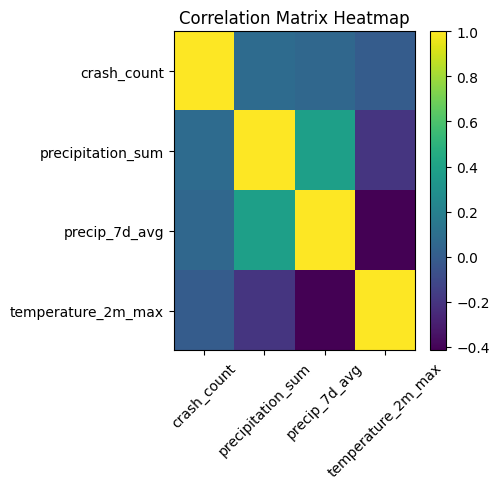

C:\Users\Aniket Shetty\AppData\Local\Temp\ipykernel_14640\1764432416.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"Cluster {c}" for c in clusters])


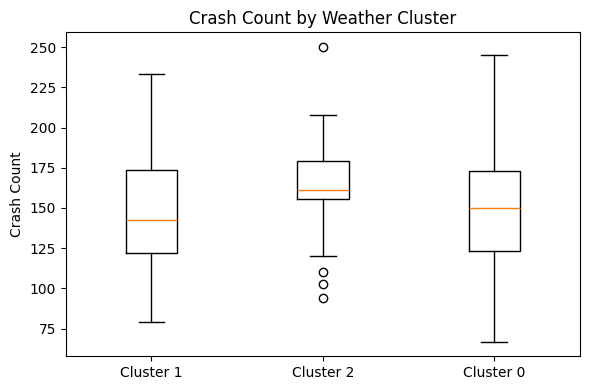

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       192
           1       0.60      0.48      0.53       207

    accuracy                           0.56       399
   macro avg       0.57      0.56      0.56       399
weighted avg       0.57      0.56      0.56       399



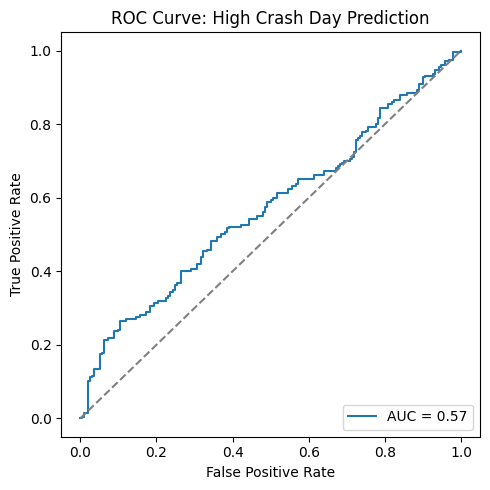

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

# ─── 2. Feature engineering ───────────────────────────────────────────────────
# Define above-average crash days
mean_crashes = daily['crash_count'].mean()
daily['high_crash_day'] = (daily['crash_count'] > mean_crashes).astype(int)

# Rolling 7-day average of precipitation
daily['precip_7d_avg'] = daily['precipitation_sum'].rolling(7, min_periods=1).mean()

# ─── 3. Correlation heatmap ─────────────────────────────────────────────────
corr = daily[['crash_count', 'precipitation_sum', 'precip_7d_avg', 'temperature_2m_max']].corr()
plt.figure(figsize=(5,5))
plt.imshow(corr.values, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# ─── 4. Boxplot by weather cluster ───────────────────────────────────────────
clusters = daily['weather_cluster'].unique()
data = [daily.loc[daily['weather_cluster']==c, 'crash_count'] for c in clusters]
plt.figure(figsize=(6,4))
plt.boxplot(data, labels=[f"Cluster {c}" for c in clusters])
plt.ylabel('Crash Count')
plt.title('Crash Count by Weather Cluster')
plt.tight_layout()
plt.show()

# ─── 5. Logistic regression for high_crash_day ───────────────────────────────
features = ['precipitation_sum', 'precip_7d_avg', 'temperature_2m_max']
X = daily[features].fillna(0)
y = daily['high_crash_day']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:,1]

print("=== Classification Report ===")
print(classification_report(y, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: High Crash Day Prediction')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Feature engineering for better results

=== Classification Report (RF w/ TimeSeriesSplit) ===
              precision    recall  f1-score   support

           0      0.633     0.693     0.662       192
           1      0.688     0.628     0.657       207

    accuracy                          0.659       399
   macro avg      0.661     0.660     0.659       399
weighted avg      0.662     0.659     0.659       399

Time-series CV AUC: 0.646



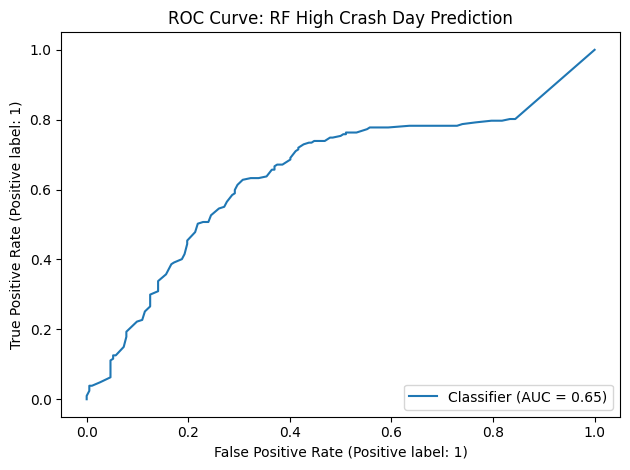

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# ─── 1. Ensure 'date' is datetime ─────────────────────────────────────────────
daily['date'] = pd.to_datetime(daily['date'], errors='coerce')

# ─── 2. Feature engineering ───────────────────────────────────────────────────
daily['heavy_rain']    = (daily['precipitation_sum'] > 5).astype(int)
daily['day_of_week']   = daily['date'].dt.dayofweek
daily['is_weekend']    = (daily['day_of_week'] >= 5).astype(int)
daily['precip_7d_avg'] = daily['precipitation_sum'].rolling(7, min_periods=1).mean()
daily['temp_7d_avg']   = daily['temperature_2m_max'].rolling(7, min_periods=1).mean()

mean_crash = daily['crash_count'].mean()
daily['high_crash_day'] = (daily['crash_count'] > mean_crash).astype(int)

# ─── 3. Prepare feature matrix X and target y ────────────────────────────────
features = [
    'precipitation_sum', 'precip_7d_avg', 'heavy_rain',
    'temperature_2m_max', 'temp_7d_avg', 'is_weekend'
]
X = daily[features].fillna(0).values
y = daily['high_crash_day'].values

# ─── 4. TimeSeriesSplit and manual CV loop ───────────────────────────────────
tscv = TimeSeriesSplit(n_splits=5)
y_pred = np.zeros_like(y)
y_prob = np.zeros_like(y, dtype=float)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train = y[train_idx]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred[test_idx] = rf.predict(X_test)
    y_prob[test_idx] = rf.predict_proba(X_test)[:, 1]

# ─── 5. Classification report & ROC curve ───────────────────────────────────
print("=== Classification Report (RF w/ TimeSeriesSplit) ===")
print(classification_report(y, y_pred, digits=3))

roc_auc = roc_auc_score(y, y_prob)
print(f"Time-series CV AUC: {roc_auc:.3f}\n")

RocCurveDisplay.from_predictions(y, y_prob)
plt.title("ROC Curve: RF High Crash Day Prediction")
plt.tight_layout()
plt.show()


# Using grid search to find best parameters using random forest(time series split)

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# ─── 2. Prepare feature matrix X and target y ────────────────────────────────
features = [
    'precipitation_sum', 'precip_7d_avg', 'heavy_rain',
    'temperature_2m_max', 'temp_7d_avg', 'is_weekend'
]
X = daily[features].fillna(0).values
y = daily['high_crash_day'].values

# ─── 3. Define TimeSeriesSplit and parameter grid ────────────────────────────
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# ─── 4. GridSearchCV ─────────────────────────────────────────────────────────
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(
    rf,
    param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid.fit(X, y)

# ─── 5. Output best parameters and score ────────────────────────────────────
print("Best parameters found:")
print(grid.best_params_)
print(f"Best time-series CV AUC: {grid.best_score_:.3f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Best time-series CV AUC: 0.785


# Final RF model

=== Final In-Sample Classification Report ===
              precision    recall  f1-score   support

           0      0.904     0.781     0.838       192
           1      0.820     0.923     0.868       207

    accuracy                          0.855       399
   macro avg      0.862     0.852     0.853       399
weighted avg      0.860     0.855     0.854       399

Overall AUC: 0.955



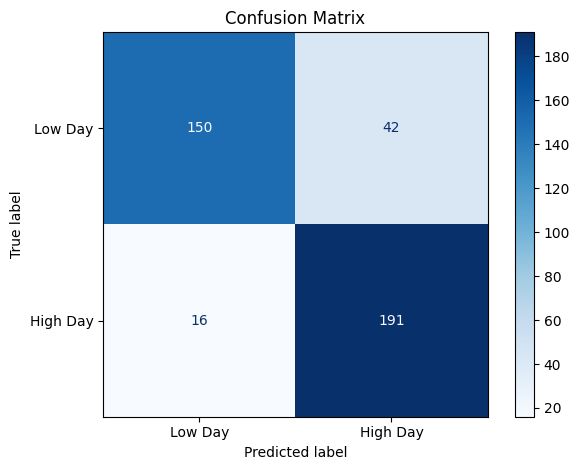

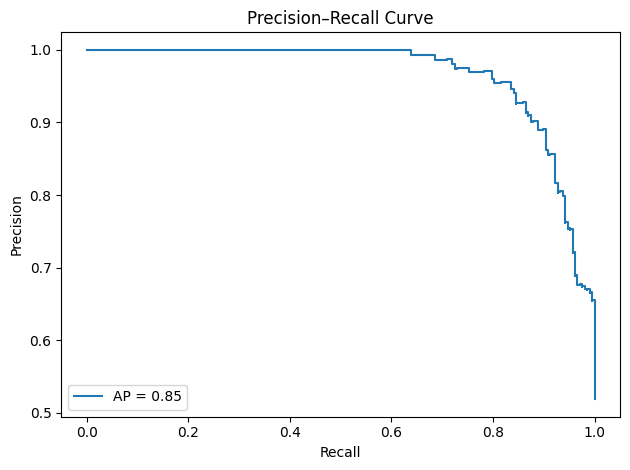

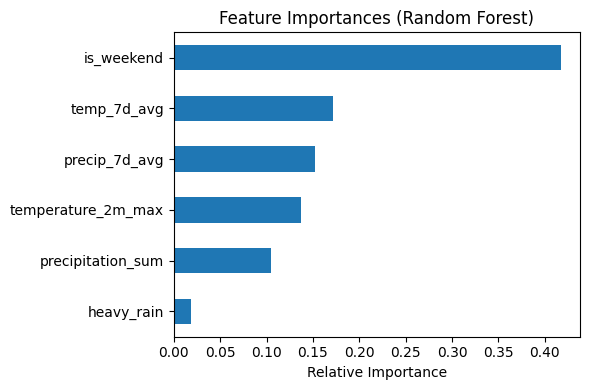

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)

# ─── 1. Reload daily data & features ─────────────────────────────────────────
daily['date'] = pd.to_datetime(daily['date'], errors='coerce')
daily['heavy_rain']    = (daily['precipitation_sum'] > 5).astype(int)
daily['day_of_week']   = daily['date'].dt.dayofweek
daily['is_weekend']    = (daily['day_of_week'] >= 5).astype(int)
daily['precip_7d_avg'] = daily['precipitation_sum'].rolling(7, min_periods=1).mean()
daily['temp_7d_avg']   = daily['temperature_2m_max'].rolling(7, min_periods=1).mean()
mean_crash = daily['crash_count'].mean()
daily['high_crash_day'] = (daily['crash_count'] > mean_crash).astype(int)

features = [
    'precipitation_sum', 'precip_7d_avg', 'heavy_rain',
    'temperature_2m_max', 'temp_7d_avg', 'is_weekend'
]
X = daily[features].fillna(0)
y = daily['high_crash_day']

# ─── 2. Fit final Random Forest ──────────────────────────────────────────────
best_params = {'n_estimators':100, 'max_depth':10, 'min_samples_leaf':5, 'random_state':42}
rf_final = RandomForestClassifier(**best_params)
rf_final.fit(X, y)
y_prob = rf_final.predict_proba(X)[:,1]
y_pred = rf_final.predict(X)

# ─── 3. Overall metrics ──────────────────────────────────────────────────────
print("=== Final In-Sample Classification Report ===")
print(classification_report(y, y_pred, digits=3))
print(f"Overall AUC: {roc_auc_score(y, y_prob):.3f}\n")

# ─── 4. Confusion matrix ─────────────────────────────────────────────────────
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Low Day','High Day']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ─── 5. Precision–Recall curve ───────────────────────────────────────────────
prec, recall, _ = precision_recall_curve(y, y_prob)
PrecisionRecallDisplay(prec, recall, average_precision=rf_final.score(X,y)).plot()
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

# ─── 6. Feature importances ─────────────────────────────────────────────────
importances = pd.Series(rf_final.feature_importances_, index=features).sort_values()
plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


# Logistic Regression Pipeline with test and train split

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# 1. Split into train / test by date
train = daily[daily['date'] < '2022-01-01']
test  = daily[daily['date'] >= '2022-01-01']

X_train = train[features]
y_train = train['high_crash_day']
X_test  = test[features]
y_test  = test['high_crash_day']

# 2. Build a preprocessing+model pipeline
pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# 3. Define a time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 4. Set up hyperparameter search
param_dist = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1','l2'],
    'clf__solver': ['saga']
}

search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_dist,
    cv=tscv, 
    scoring='roc_auc',
    n_iter=20, 
    n_jobs=-1, 
    verbose=1
)

# 5. Fit & evaluate
search.fit(X_train, y_train)
print("Best CV AUC:", search.best_score_)
print("Test  AUC:", roc_auc_score(y_test, search.predict_proba(X_test)[:,1]))


C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV AUC: 0.7855082247029509
Test  AUC: 0.7283333333333333


# Random Forest Model with test train split

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# 1. Re-use your train/test split
train = daily[daily['date'] < '2022-01-01']
test  = daily[daily['date'] >= '2022-01-01']

X_train, y_train = train[features], train['high_crash_day']
X_test,  y_test  = test [features], test ['high_crash_day']

# 2. Build the preprocessing+RF pipeline
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),            # RFs don’t strictly need scaling, but harmless here
    ('clf',    RandomForestClassifier(random_state=42))
])

# 3. Define your time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 4. Set up hyperparameter search for RF
param_dist = {
    'clf__n_estimators':    [100, 200, 500],
    'clf__max_depth':       [None, 5, 10, 20],
    'clf__min_samples_leaf':[1, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    cv=tscv,
    scoring='roc_auc',
    n_iter=20,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 5. Fit and evaluate
rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best RF CV AUC:", rf_search.best_score_)
print("RF Test   AUC:", roc_auc_score(y_test, rf_search.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'clf__n_estimators': 100, 'clf__min_samples_leaf': 5, 'clf__max_depth': 20}
Best RF CV AUC: 0.7669726569538943
RF Test   AUC: 0.7716666666666667


# Gradient Boosting Classifier with test train split

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# 1. Train/test split by date
train = daily[daily['date'] < '2022-01-01']
test  = daily[daily['date'] >= '2022-01-01']

X_train, y_train = train[features], train['high_crash_day']
X_test,  y_test  = test[ features], test[ 'high_crash_day']

# 2. Build a preprocessing + GBM pipeline
gbm_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),     # HistGBM often works fine without scaling, but it's harmless
    ('clf',   HistGradientBoostingClassifier(random_state=42))
])

# 3. TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 4. Hyperparameter distributions
param_dist = {
    'clf__max_iter':      [100, 200, 500],
    'clf__max_depth':     [None, 3, 5, 10],
    'clf__min_samples_leaf': [10, 20, 50],
    'clf__learning_rate': [0.01, 0.05, 0.1]
}

search_gbm = RandomizedSearchCV(
    gbm_pipe,
    param_distributions=param_dist,
    cv=tscv,
    scoring='roc_auc',
    n_iter=20,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 5. Fit & evaluate
search_gbm.fit(X_train, y_train)

print("Best GBM params:  ", search_gbm.best_params_)
print("GBM CV  AUC:    ", search_gbm.best_score_)
print("GBM Test AUC:   ",
      roc_auc_score(y_test, search_gbm.predict_proba(X_test)[:,1]))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best GBM params:   {'clf__min_samples_leaf': 10, 'clf__max_iter': 100, 'clf__max_depth': None, 'clf__learning_rate': 0.01}
GBM CV  AUC:     0.783766900686272
GBM Test AUC:    0.7968518518518518


# Comparing the model performances

In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming you have already run your hyperparameter searches:
#   - `search`      is the RandomizedSearchCV for the Logistic pipeline
#   - `rf_search`   is the RandomizedSearchCV for the RF pipeline
#   - `search_gbm`  is the RandomizedSearchCV for the GBM pipeline
# and that X_test, y_test are defined as in your train/test split.

# 1. Gather the best estimators and their CV AUCs
models = {
    'Logistic':        search.best_estimator_,
    'RandomForest':    rf_search.best_estimator_,
    'GBM':             search_gbm.best_estimator_
}

cv_scores = {
    'Logistic':     search.best_score_,
    'RandomForest': rf_search.best_score_,
    'GBM':          search_gbm.best_score_
}

# 2. Evaluate each on the hold-out test set
rows = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    rows.append({
        'Model':    name,
        'CV AUC':   cv_scores[name],
        'Test AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall':    recall_score(y_test, y_pred),
        'F1-score':  f1_score(y_test, y_pred)
    })

# 3. Build and display the summary table
summary_df = pd.DataFrame(rows)
print(summary_df)


          Model    CV AUC  Test AUC  Accuracy  Precision    Recall  F1-score
0      Logistic  0.785508  0.728333  0.714286   0.663366  0.893333  0.761364
1  RandomForest  0.766973  0.771667  0.707483   0.686047  0.786667  0.732919
2           GBM  0.783767  0.796852  0.700680   0.696203  0.733333  0.714286


# Refining the best model

=== GBM Test Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        72
           1       0.70      0.73      0.71        75

    accuracy                           0.70       147
   macro avg       0.70      0.70      0.70       147
weighted avg       0.70      0.70      0.70       147



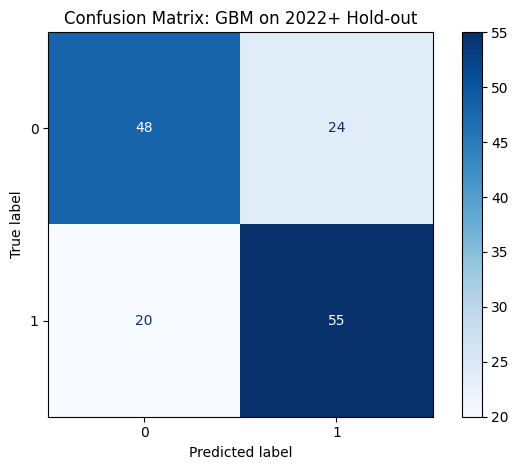

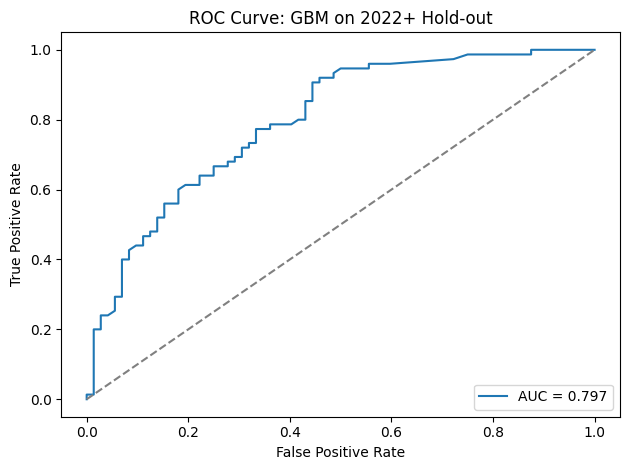

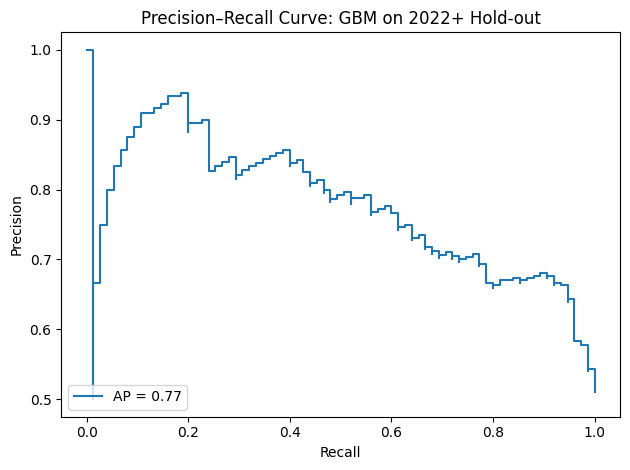

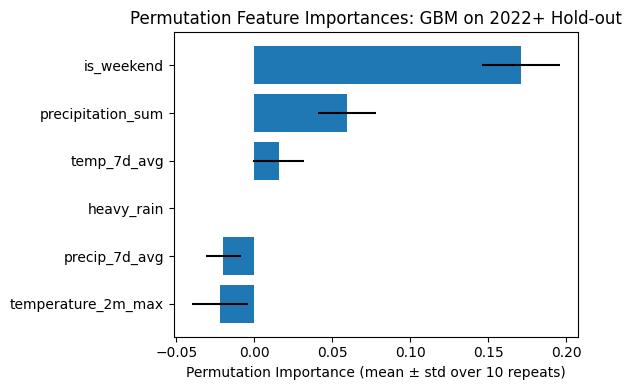

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay
)
from sklearn.inspection import permutation_importance

# 1. Get the best GBM pipeline and the clf itself
gbm_pipe = search_gbm.best_estimator_
gbm_clf  = gbm_pipe.named_steps['clf']

# 2. Predict on the test set
y_pred = gbm_pipe.predict(X_test)
y_prob = gbm_pipe.predict_proba(X_test)[:, 1]

# 3. Classification report
print("=== GBM Test Classification Report ===")
print(classification_report(y_test, y_pred))

# 4. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=gbm_clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: GBM on 2022+ Hold-out")
plt.tight_layout()
plt.show()

# 5. ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: GBM on 2022+ Hold-out")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 6. Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)
PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=pr_auc).plot()
plt.title("Precision–Recall Curve: GBM on 2022+ Hold-out")
plt.tight_layout()
plt.show()

# 7. Permutation-based feature importances
results = permutation_importance(
    gbm_pipe,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# sort features by importance
sorted_idx = np.argsort(results.importances_mean)
feat_names = np.array(features)[sorted_idx]
importances = results.importances_mean[sorted_idx]
importances_std = results.importances_std[sorted_idx]

plt.figure(figsize=(6, 4))
plt.barh(feat_names, importances, xerr=importances_std, align='center')
plt.xlabel("Permutation Importance (mean ± std over 10 repeats)")
plt.title("Permutation Feature Importances: GBM on 2022+ Hold-out")
plt.tight_layout()
plt.show()


# Fine tuning the model

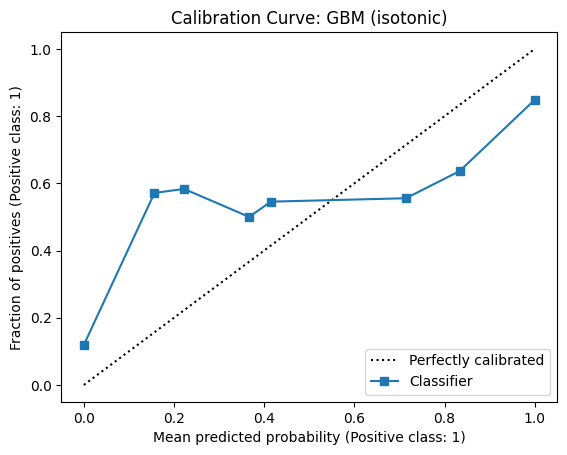

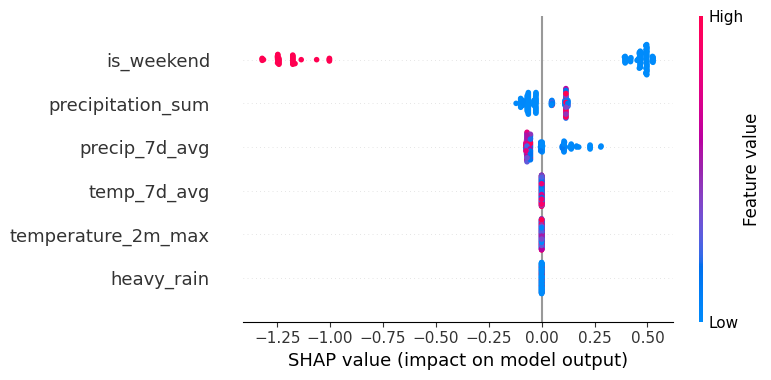

In [34]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay

import shap

# wrap your best GBM in a CalibratedClassifierCV
calibrator = CalibratedClassifierCV(gbm_pipe, cv='prefit', method='isotonic')
calibrator.fit(X_train, y_train)

# evaluate calibration on hold-out
y_prob_cal = calibrator.predict_proba(X_test)[:,1]
disp = CalibrationDisplay.from_predictions(y_test, y_prob_cal, n_bins=10)
plt.title("Calibration Curve: GBM (isotonic)")
plt.show()


# explain the model predictions using SHAP
explainer = shap.Explainer(calibrator if hasattr(calibrator, "base_estimator_") else gbm_clf, X_train)
shap_values = explainer(X_test)

# summary plot
shap.summary_plot(shap_values, X_test, feature_names=features, max_display=10)


# Threshold‐Sweep & Decision Analysis

C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aniket Shetty\anaconda

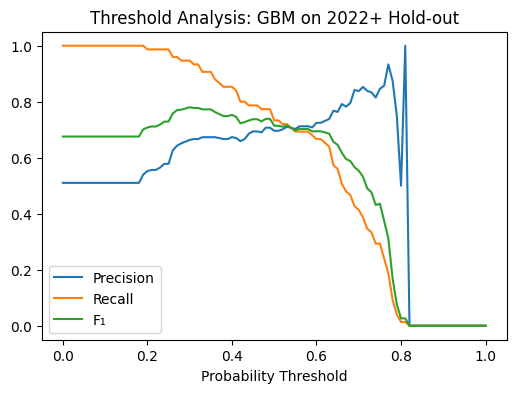

In [35]:
import numpy as np

thresholds = np.linspace(0,1,101)
precisions = []
recalls    = []
f1s        = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    rep = classification_report(y_test, y_pred_t, output_dict=True)
    precisions.append(rep['1']['precision'])
    recalls.append   (rep['1']['recall'])
    f1s.append       (rep['1']['f1-score'])

plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls,    label='Recall')
plt.plot(thresholds, f1s,        label='F₁')
plt.xlabel('Probability Threshold')
plt.legend()
plt.title('Threshold Analysis: GBM on 2022+ Hold‐out')
plt.show()


# Cost‐Sensitive Metrics

In [37]:
from sklearn.metrics import fbeta_score

# e.g. weight recall twice as important as precision → F2
f2 = fbeta_score(y_test, (y_prob>=0.5).astype(int), beta=2)
print("F₂ (β=2) at 0.5 threshold:", f2)

fp = ((y_test==0)&(y_pred==1)).sum()
fn = ((y_test==1)&(y_pred==0)).sum()
cost = fp*1 + fn*2
print("Total cost (FP=1, FN=2):", cost)


F₂ (β=2) at 0.5 threshold: 0.7255936675461742
Total cost (FP=1, FN=2): 64


# Partial Dependence / Individual Conditional Expectation

C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\Aniket Shetty\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\Aniket Shetty\anaconda3\Lib\site-pac

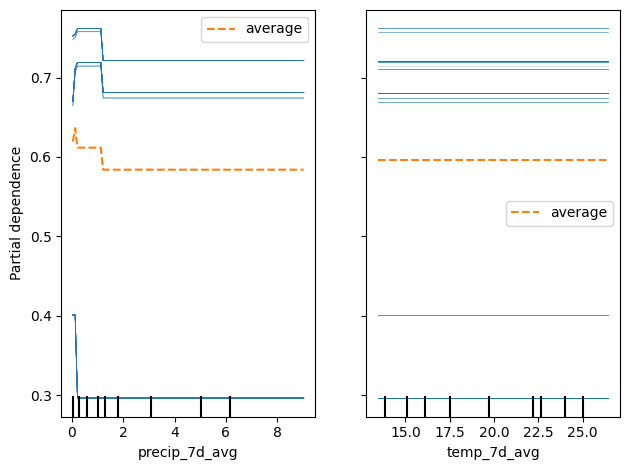

In [38]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    gbm_clf, X_test, ['precip_7d_avg','temp_7d_avg'],
    kind='both', subsample=100
)
plt.tight_layout()
plt.show()


# Crash Risk Analysis

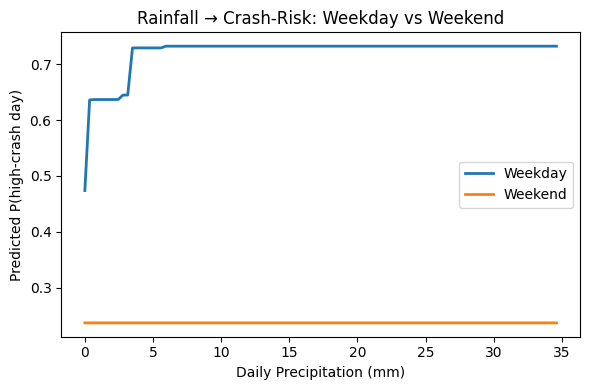

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Grab back your test‐features DataFrame (with the raw columns)
#    (we assume X_test is a pd.DataFrame containing at least
#     ['precipitation_sum','is_weekend', …] exactly as in your pipeline)
#    and gbm_pipe is your fitted Pipeline (imputer→scaler→clf).

# 2) Define a fine grid of rainfall values
precip_grid = np.linspace(
    X_test['precipitation_sum'].min(),
    X_test['precipitation_sum'].max(),
    100
)

# 3) For each value in the grid, overwrite precipitation_sum in a copy of X_test,
#    predict_proba, then average separately for weekends vs weekdays.
avg_pred_weekday = []
avg_pred_weekend = []

for p in precip_grid:
    X_tmp = X_test.copy()
    X_tmp['precipitation_sum'] = p
    probs = gbm_pipe.predict_proba(X_tmp)[:,1]
    # mask by weekend flag
    avg_pred_weekday.append(probs[X_tmp['is_weekend']==0].mean())
    avg_pred_weekend.append(probs[X_tmp['is_weekend']==1].mean())

# 4) Plot
plt.figure(figsize=(6,4))
plt.plot(precip_grid, avg_pred_weekday, label='Weekday', lw=2)
plt.plot(precip_grid, avg_pred_weekend, label='Weekend', lw=2)
plt.xlabel("Daily Precipitation (mm)")
plt.ylabel("Predicted P(high-crash day)")
plt.title("Rainfall → Crash-Risk: Weekday vs Weekend")
plt.legend()
plt.tight_layout()
plt.show()


# Robustness Check

Bootstrap results (mean, 95% CI):
 AUC      : 0.797 [0.715, 0.865]
 Accuracy : 0.701 [0.626, 0.776]
 Precision: 0.698 [0.595, 0.795]
 Recall   : 0.733 [0.636, 0.829]
 F1       : 0.714 [0.630, 0.790]


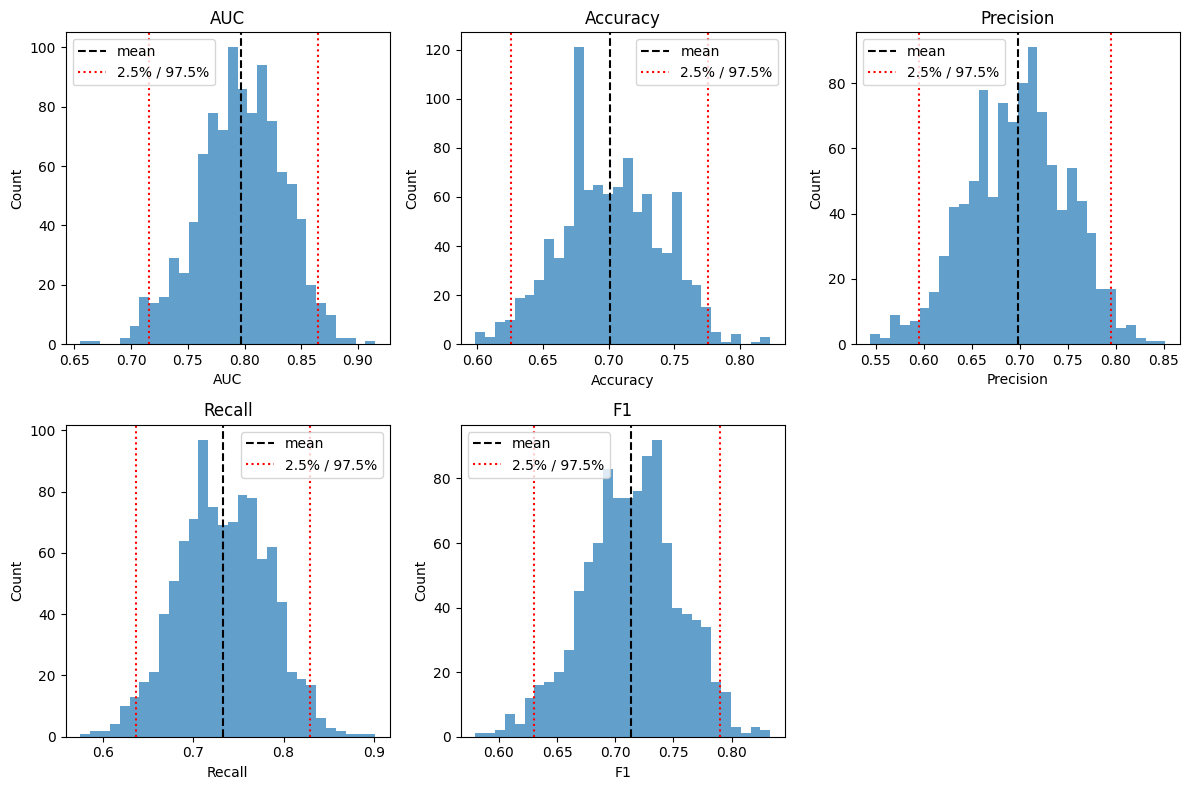

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# pull your test set into numpy arrays
y_test_arr = y_test.to_numpy()
y_prob_arr = gbm_pipe.predict_proba(X_test)[:,1]

n = len(y_test_arr)
n_boot = 1000
rng = np.random.RandomState(42)

# storage
aucs = np.zeros(n_boot)
accs = np.zeros(n_boot)
ps   = np.zeros(n_boot)
rs   = np.zeros(n_boot)
f1s  = np.zeros(n_boot)

for i in range(n_boot):
    idx = rng.randint(0, n, n)       # sample positions
    y_true_bs = y_test_arr[idx]
    y_prob_bs = y_prob_arr[idx]
    y_pred_bs = (y_prob_bs >= 0.5).astype(int)
    
    aucs[i] = roc_auc_score(y_true_bs, y_prob_bs)
    accs[i] = accuracy_score(y_true_bs, y_pred_bs)
    ps[i]   = precision_score(y_true_bs, y_pred_bs, zero_division=0)
    rs[i]   = recall_score(y_true_bs, y_pred_bs)
    f1s[i]  = f1_score(y_true_bs, y_pred_bs)

def ci95(x):
    lo, hi = np.percentile(x, [2.5, 97.5])
    return x.mean(), lo, hi

metrics = {
    'AUC'      : aucs,
    'Accuracy' : accs,
    'Precision': ps,
    'Recall'   : rs,
    'F1'       : f1s
}

print("Bootstrap results (mean, 95% CI):")
for name, vals in metrics.items():
    mean, lo, hi = ci95(vals)
    print(f" {name:9}: {mean:.3f} [{lo:.3f}, {hi:.3f}]")

# plot distributions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, vals) in zip(axes, metrics.items()):
    ax.hist(vals, bins=30, alpha=0.7)
    ax.axvline(vals.mean(), color='k', linestyle='--', label='mean')
    lo, hi = np.percentile(vals, [2.5, 97.5])
    ax.axvline(lo, color='r', linestyle=':', label='2.5% / 97.5%')
    ax.axvline(hi, color='r', linestyle=':')
    ax.set_title(name)
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    ax.legend()

# drop the empty subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()
